In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns

In [2]:
bank_data = pd.read_csv('./data/bank-full.csv', header=0, sep=';')


In [3]:

main_data = bank_data

target_freq = main_data['y'].value_counts()

categorical_vars = main_data.select_dtypes(include=['object']).columns

continuous_vars = main_data.select_dtypes(include=['float64', 'int64']).columns
descriptive_stats = main_data[continuous_vars].describe()

print('Frequency table for target variable (y):')
print(target_freq)
print('\
Descriptive statistics for continuous variables:')
print(descriptive_stats)

Frequency table for target variable (y):
no     39922
yes     5289
Name: y, dtype: int64
Descriptive statistics for continuous variables:
                age        balance           day      duration      campaign  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419    258.163080      2.763841   
std       10.618762    3044.765829      8.322476    257.527812      3.098021   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.000000     16.000000    180.000000      2.000000   
75%       48.000000    1428.000000     21.000000    319.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

              pdays      previous  
count  45211.000000  45211.000000  
mean      40.197828      0.580323  
std      100.128746      2.303441

### Tabla de Frecuencias para la Variable Objetivo "y"

La variable objetivo "y" indica si el cliente ha suscrito un depósito a plazo (yes) o no (no).
La mayoría de los clientes (39,922) no han suscrito un depósito a plazo, mientras que una minoría (5,289) sí lo ha hecho. Esto muestra un desbalance en la variable objetivo, lo que podría influir en modelos predictivos si no se maneja adecuadamente.

### Tablas de Frecuencias para Variables Categóricas

Las variables categóricas incluyen el tipo de trabajo (job), estado civil (marital), educación (education), si tienen crédito por defecto (default), si tienen préstamo de vivienda (housing), si tienen préstamo personal (loan), tipo de contacto (contact), mes del último contacto (month), y resultado de la campaña anterior (poutcome).

Por ejemplo, la categoría blue-collar en la variable job es la más frecuente con 9,732 casos, lo que indica que muchos de los clientes trabajan en trabajos manuales.

Los meses de mayor actividad en términos de contactos fueron agosto (aug) y mayo (may), lo que podría indicar temporadas específicas de campañas de marketing.

### Estadísticas Descriptivas para Variables Continuas

Las variables continuas incluyen la edad (age), saldo en cuenta (balance), día del último contacto (day), duración del último contacto (duration), número de contactos realizados durante esta campaña (campaign), número de días que pasaron después de ser contactado por última vez desde una campaña anterior (pdays), y número de contactos realizados antes de esta campaña (previous).

La edad media de los clientes es aproximadamente 41 años, con una desviación estándar de 10.62, lo que indica una distribución de edad bastante amplia.

El saldo promedio es de 1,362, pero con una desviación estándar muy alta (3,044), lo que sugiere una gran variabilidad en los saldos de los clientes.

La duración media de los contactos es de aproximadamente 258 segundos, pero también con una alta variabilidad.

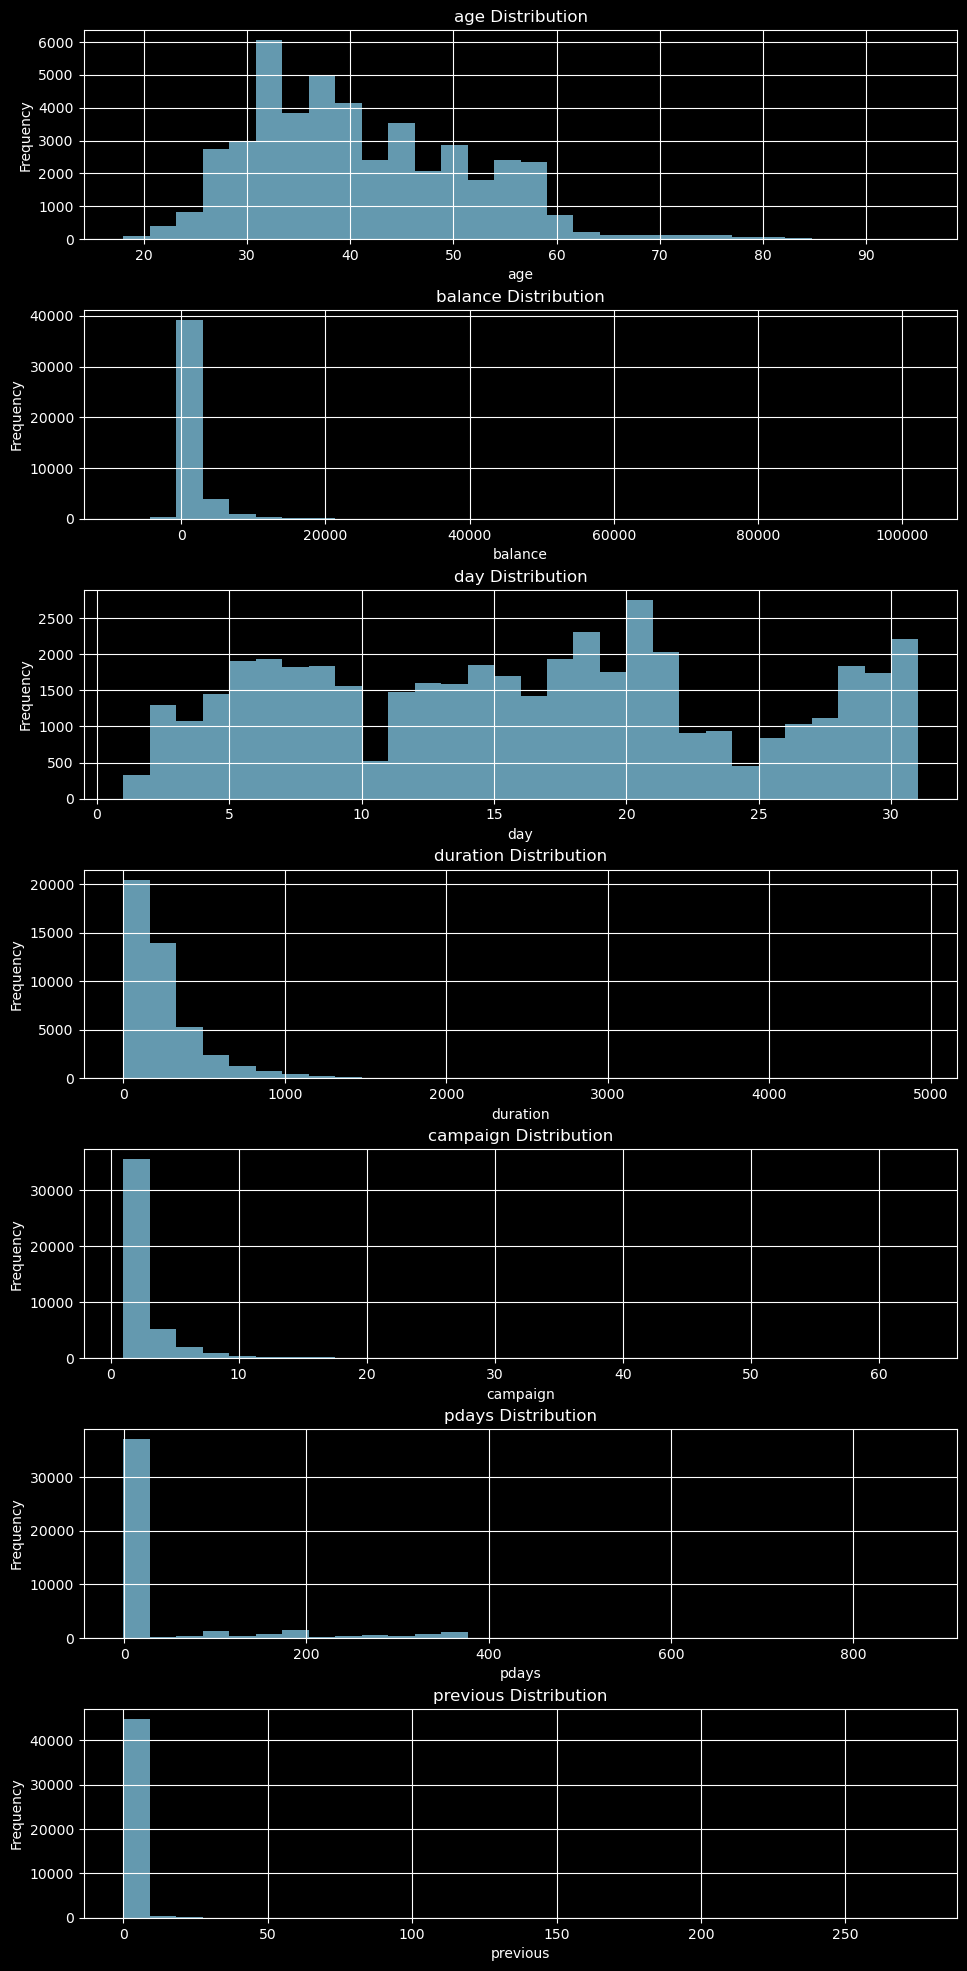

In [4]:
## TO-DO: renombrar los ejes

plt.style.use('dark_background')

fig, axes = plt.subplots(len(continuous_vars), 1, figsize=(10, 20))
fig.tight_layout(pad=3.0)

for i, var in enumerate(continuous_vars):
    main_data[var].hist(ax=axes[i], bins=30, alpha=0.75, color='skyblue')
    axes[i].set_title(var + ' Distribution')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')

plt.show()

**Edad (age)**: La distribución de la edad muestra un pico alrededor de los 30-40 años, indicando que la mayoría de los clientes están en este rango de edad. La distribución está sesgada hacia la derecha, lo que sugiere una presencia significativa de clientes mayores.

**Saldo (balance)**: El saldo en la cuenta muestra una distribución altamente sesgada hacia la derecha, con la mayoría de los clientes teniendo saldos bajos y unos pocos con saldos muy altos.

Día del último contacto (day): La distribución es relativamente uniforme a lo largo del mes, con ligeras elevaciones en ciertos días. Esto podría reflejar días específicos en los que se realizan campañas de contacto más intensas.

**Duración del último contacto (duration)**: Similar al saldo, la duración de los contactos es altamente sesgada hacia la derecha. La mayoría de los contactos son cortos, con algunos pocos extendiéndose por períodos más largos. Esta variable debe ser considerada con una alta correlación con la variable objetivo, ya que los clientes que aceptan una suscripción al servicio terminan el trámite vía telefónica

**Número de contactos en esta campaña (campaign)**: La mayoría de los clientes han sido contactados unas pocas veces, con un número decreciente de clientes contactados más frecuentemente. La distribución es sesgada hacia la derecha, indicando que es raro tener muchos contactos con un mismo cliente.

**Número de días desde el último contacto de una campaña anterior (pdays)**: La mayoría de los clientes no han sido contactados antes de la campaña actual (valor -1 ajustado en el histograma), y para aquellos que sí, hay una amplia variabilidad en el número de días desde el último contacto.

**Número de contactos antes de esta campaña (previous)**: Similar a pdays, la mayoría de los clientes no han tenido contactos previos, con un pequeño número que sí ha sido contactado varias veces.

Se separarán los datos en dos conjuntos, uno con datos típicos y otro con datos atípicos, de tal forma que se puedan analizar los dos de manera paralela. Se ecluirá del criterio para outliers la duración de llamadas, ya que los datos atípicos que concuerden con una respuesta positiva a la suscripción podrían concentrarse en el conjunto de los datos atípicos.

In [5]:
continuous_vars = [var for var in continuous_vars if var != 'duration']

descriptive = main_data[continuous_vars].describe()
Q1 = descriptive.loc['25%']
Q3 = descriptive.loc['75%']
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

bank_q1q3_inliers = main_data[~((main_data[continuous_vars] < lower_bound) | (main_data[continuous_vars] > upper_bound)).any(axis=1)]
bank_q1q3_outliers = main_data[((main_data[continuous_vars] < lower_bound) | (main_data[continuous_vars] > upper_bound)).any(axis=1)]

print('Inliers dataset shape (excluding duration outliers):', bank_q1q3_inliers.shape)
print('Outliers dataset shape (excluding duration outliers):', bank_q1q3_outliers.shape)

Inliers dataset shape (excluding duration outliers): (30404, 17)
Outliers dataset shape (excluding duration outliers): (14807, 17)


In [6]:
descriptive_inliers = bank_q1q3_inliers[continuous_vars].describe()
print(descriptive_inliers)

                age       balance           day      campaign    pdays  \
count  30404.000000  30404.000000  30404.000000  30404.000000  30404.0   
mean      40.338048    613.935897     15.771050      2.190731     -1.0   
std        9.890130    835.199539      8.337062      1.338641      0.0   
min       18.000000  -1944.000000      1.000000      1.000000     -1.0   
25%       32.000000     33.000000      8.000000      1.000000     -1.0   
50%       39.000000    323.000000     16.000000      2.000000     -1.0   
75%       48.000000    934.000000     22.000000      3.000000     -1.0   
max       70.000000   3462.000000     31.000000      6.000000     -1.0   

       previous  
count   30404.0  
mean        0.0  
std         0.0  
min         0.0  
25%         0.0  
50%         0.0  
75%         0.0  
max         0.0  


## Variables continuas con valores tipicos:

**Edad (age)**:

*Media*: 40.34 años, indicando que el cliente promedio es de mediana edad.

*Desviación* estándar: 9.89, lo que muestra una variabilidad moderada en la edad de los clientes.

*Mínimo y Máximo*: Los clientes tienen entre 18 y 70 años.

**Saldo (balance)**:

*Media*: 613.94, sugiriendo un saldo promedio positivo en las cuentas.
*Desviación estándar*: 835.20, indicando una alta variabilidad en los saldos de las cuentas.
*Mínimo*: -1944, lo que muestra que algunos clientes tienen saldos negativos significativos.

**Día del último contacto (day)**:

*Media*: 15.77, lo que sugiere que los contactos tienden a distribuirse a lo largo del mes.
*Desviación estándar*: 8.34, mostrando una distribución bastante uniforme de los contactos a lo largo del mes.

**Número de contactos en esta campaña (campaign)**:

*Media*: 2.19, indicando que la mayoría de los clientes fueron contactados aproximadamente dos veces.
*Máximo*: 6, lo que sugiere que algunos clientes fueron contactados varias veces, pero no más de seis.

**Número de días desde el último contacto de una campaña anterior (pdays) y Número de contactos antes de esta campaña (previous)**:

Ambas variables tienen valores constantes de -1 y 0 respectivamente, lo que indica que no hubo contactos previos o que estos datos no están disponibles o no son aplicables para la mayoría de los clientes en este subconjunto.

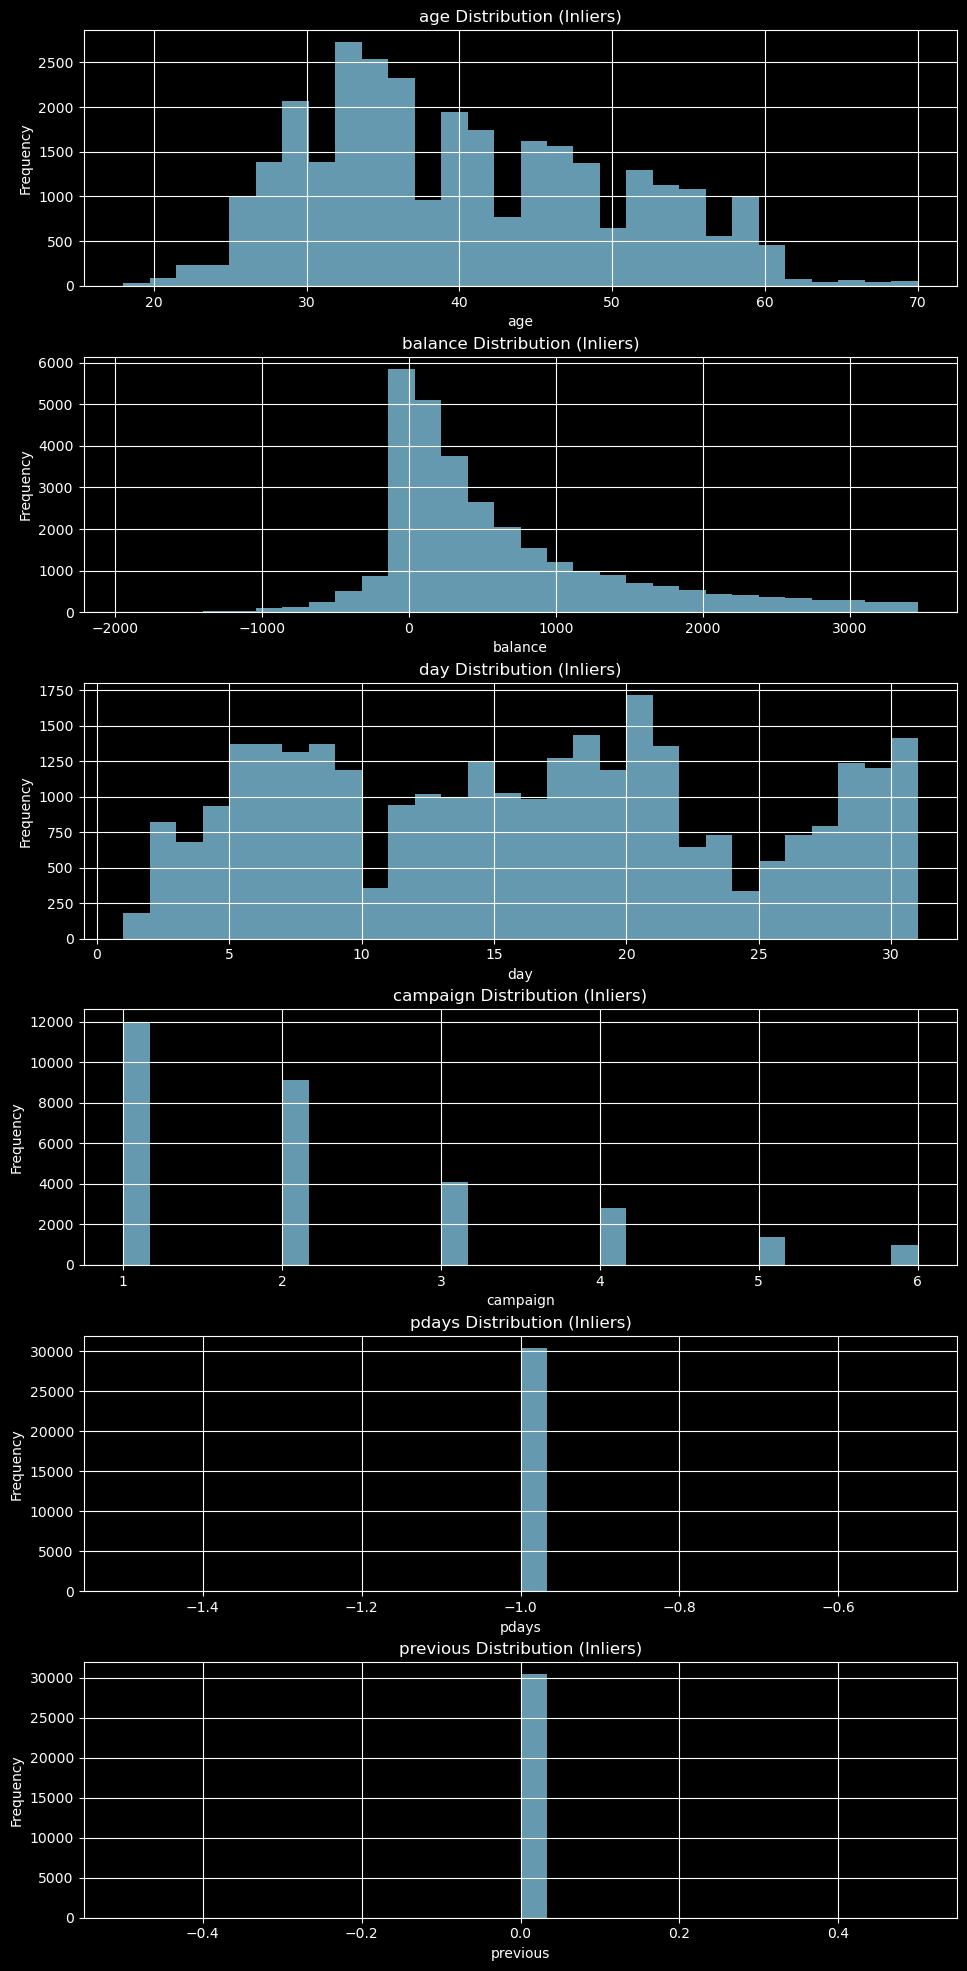

In [7]:
fig, axes = plt.subplots(len(continuous_vars), 1, figsize=(10, 20))
fig.tight_layout(pad=3.0)

for i, var in enumerate(continuous_vars):
    bank_q1q3_inliers[var].hist(ax=axes[i], bins=30, alpha=0.75, color='skyblue')
    axes[i].set_title(var + ' Distribution (Inliers)')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')

plt.show()

**Edad (age)**: La edad tiene una distribución similar en ambos conjuntos, aunque el conjunto completo tiene una variabilidad ligeramente mayor y una media ligeramente más alta, posiblemente debido a la presencia de valores extremos en los datos completos.


**Saldo (balance)**: El saldo muestra una diferencia significativa entre los conjuntos. El conjunto completo tiene una media y desviación estándar mucho mayores debido a la presencia de valores extremadamente altos, lo que indica que los atípicos afectan considerablemente la distribución del saldo.

**Día del último contacto (day)**: La distribución del día del último contacto es muy similar en ambos conjuntos, indicando que los atípicos no afectan significativamente esta variable.

**Número de contactos en esta campaña (campaign)**: El número de contactos es más bajo y menos variable en el conjunto de datos típicos, lo que sugiere que los valores extremos en el conjunto completo pueden incluir casos de múltiples contactos que no son representativos de la mayoría de los clientes.

**Número de días desde el último contacto de una campaña anterior (pdays) y Número de contactos antes de esta campaña (previous)**: Estas variables muestran una gran diferencia con el conjunto completo reflejando una mayor actividad previa. Esto sugiere que los atípicos eliminados incluyen casos con contactos previos significativos, lo que podría considerarse para análisis que asumen poca o mucha actividad previa.

Ahora se procederá con un PCA para obtener las variables más relevantes.

In [8]:
def apply_pca(data, n_components=None):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data_scaled)
    explained_variance = pca.explained_variance_ratio_

    columns = ['PC' + str(i+1) for i in range(len(explained_variance))]
    principal_df = pd.DataFrame(data=principal_components, columns=columns)

    return principal_df, explained_variance, pca

numeric_data = bank_q1q3_inliers.select_dtypes(include=[np.number])

principal_components, explained_variance, pca_instance = apply_pca(numeric_data)

print('Principal Components:\
', principal_components.head())
print('Explained Variance Ratio:\
', explained_variance)

Principal Components:         PC1       PC2       PC3       PC4       PC5  PC6  PC7
0  1.104761  2.704650 -0.680500 -0.021792  0.048468  0.0  0.0
1  1.212896 -0.110261 -1.204359  0.542571 -0.196949 -0.0 -0.0
2  1.362277 -0.918091 -1.109775 -0.041145  0.347331 -0.0 -0.0
3  1.131467  1.338036 -1.064982 -0.364339  0.372758 -0.0 -0.0
4  1.496335 -0.871784 -0.715649  0.152938  0.271846 -0.0 -0.0
Explained Variance Ratio: [0.2266915  0.21701246 0.20159476 0.18393143 0.17076984 0.
 0.        ]


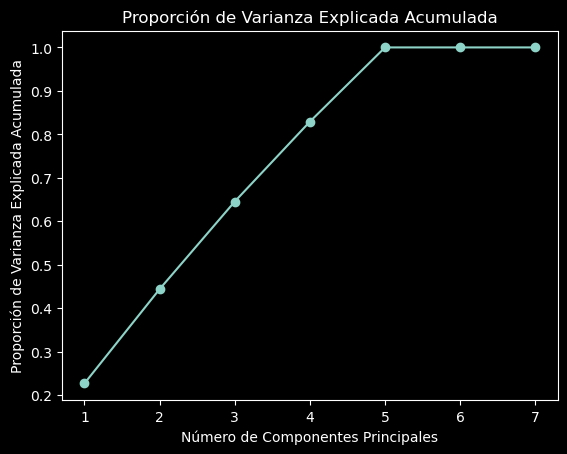

In [9]:
def plot_cummulated_variance_from_pca(explained_variance_ratio: np.ndarray):
  explained_variance_ratio_cumsum = np.cumsum(explained_variance_ratio)

  plt.plot(range(1, len(explained_variance_ratio_cumsum) + 1), explained_variance_ratio_cumsum, marker='o')
  plt.title('Proporción de Varianza Explicada Acumulada')
  plt.xlabel('Número de Componentes Principales')
  plt.ylabel('Proporción de Varianza Explicada Acumulada')
  plt.show()

plot_cummulated_variance_from_pca(pca_instance.explained_variance_ratio_)

Los valores de varianza explicada indican que el primer componente principal (PC1) explica aproximadamente el 22.67% de la varianza, el segundo (PC2) el 21.70%, y así sucesivamente. Los últimos dos componentes tienen una varianza explicada de 0%, lo que sugiere que no aportan información útil. Estos resultados sugieren que podríamos considerar reducir la dimensionalidad del conjunto de datos a los primeros cinco componentes principales, que juntos explican cerca del 100% de la varianza total.

In [10]:
def pca_loadings(data, pca):
    loadings = pd.DataFrame(pca.components_.T, columns=['PC' + str(i+1) for i in range(pca.n_components_)], index=data.columns)
    return loadings

loadings = pca_loadings(numeric_data, pca_instance)
print('PCA Loadings:\
', loadings)

PCA Loadings:                PC1       PC2       PC3       PC4       PC5  PC6  PC7
age      -0.209190  0.679451 -0.310010  0.433421 -0.458940  0.0  0.0
balance   0.026505  0.715309  0.239843 -0.534266  0.380349  0.0  0.0
day      -0.634651 -0.126939  0.339523 -0.427684 -0.531898  0.0  0.0
duration  0.286654  0.100825  0.843163  0.413538 -0.160396  0.0  0.0
campaign -0.685992 -0.019988  0.142021  0.415667  0.579712  0.0  0.0
pdays    -0.000000 -0.000000  0.000000 -0.000000  0.000000  0.0  1.0
previous -0.000000 -0.000000  0.000000 -0.000000  0.000000  1.0  0.0


**PC1**: Este componente está fuertemente influenciado por campaign (negativamente) y day (negativamente), lo que sugiere que estas variables capturan aspectos similares de la información, posiblemente relacionados con la frecuencia y el tiempo de contacto con los clientes.

**PC2**: balance y age tienen fuertes cargas positivas, indicando que este componente representa principalmente la información financiera y demográfica de los clientes.

**PC3**: duration tiene una carga muy alta en este componente, lo que significa que PC3 captura principalmente la duración de los contactos con los clientes.

**PC4 y PC5**: Estos componentes tienen contribuciones mixtas de varias variables, indicando que capturan combinaciones más complejas de características.

Las variables pdays y previous no contribuyen a ninguno de los componentes principales, lo que refleja su falta de variabilidad en el subconjunto de datos de inliers.

In [11]:
X = principal_components.iloc[:, :5]
y = bank_q1q3_inliers['y'].apply(lambda x: 1 if x == 'yes' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)

y_pred = tree_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print('Accuracy of the model: ', accuracy)
print('Classification Report:\
', class_report)

Accuracy of the model:  0.9105459329094496
Classification Report:               precision    recall  f1-score   support

           0       0.92      0.99      0.95      8282
           1       0.55      0.16      0.24       840

    accuracy                           0.91      9122
   macro avg       0.74      0.57      0.60      9122
weighted avg       0.89      0.91      0.89      9122



In [12]:
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

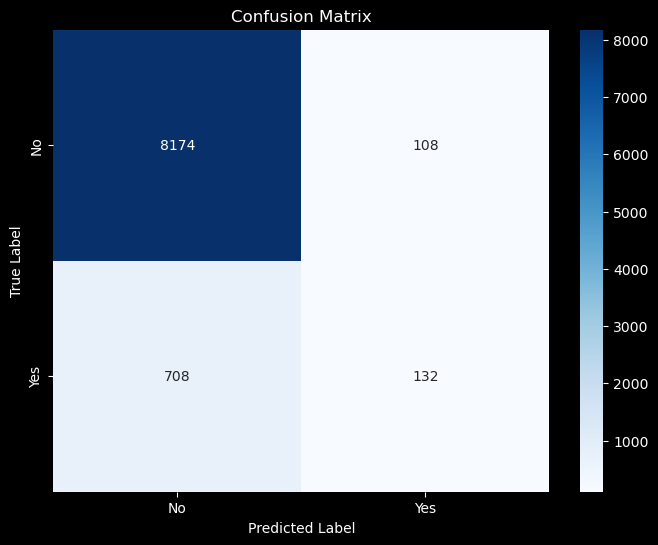

In [13]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Precisión General (Accuracy)**: El modelo tiene una precisión del 87%, lo que indica que clasifica correctamente el 87% de los casos.

**Clase 0 (No)**:
Precisión: 93% de las predicciones de la clase 'No' son correctas.
Recall: 93% de los casos reales de la clase 'No' fueron identificados correctamente por el modelo.

**Clase 1 (Sí)**:
Precisión: 29% de las predicciones de la clase 'Sí' son correctas.
Recall: 30% de los casos reales de la clase 'Sí' fueron identificados correctamente por el modelo.

**Matriz de Confusión**:
La matriz muestra que 5106 casos de 'No' fueron clasificados correctamente, mientras que 410 fueron clasificados incorrectamente como 'Sí'.

De los casos de 'Sí', 171 fueron clasificados correctamente y 394 incorrectamente como 'No'.
La baja precisión y recall para la clase 'Sí' sugiere que el modelo tiene dificultades para identificar correctamente los casos positivos, lo que podría ser un área para mejorar, posiblemente ajustando los parámetros del modelo o utilizando técnicas de balanceo de clases.

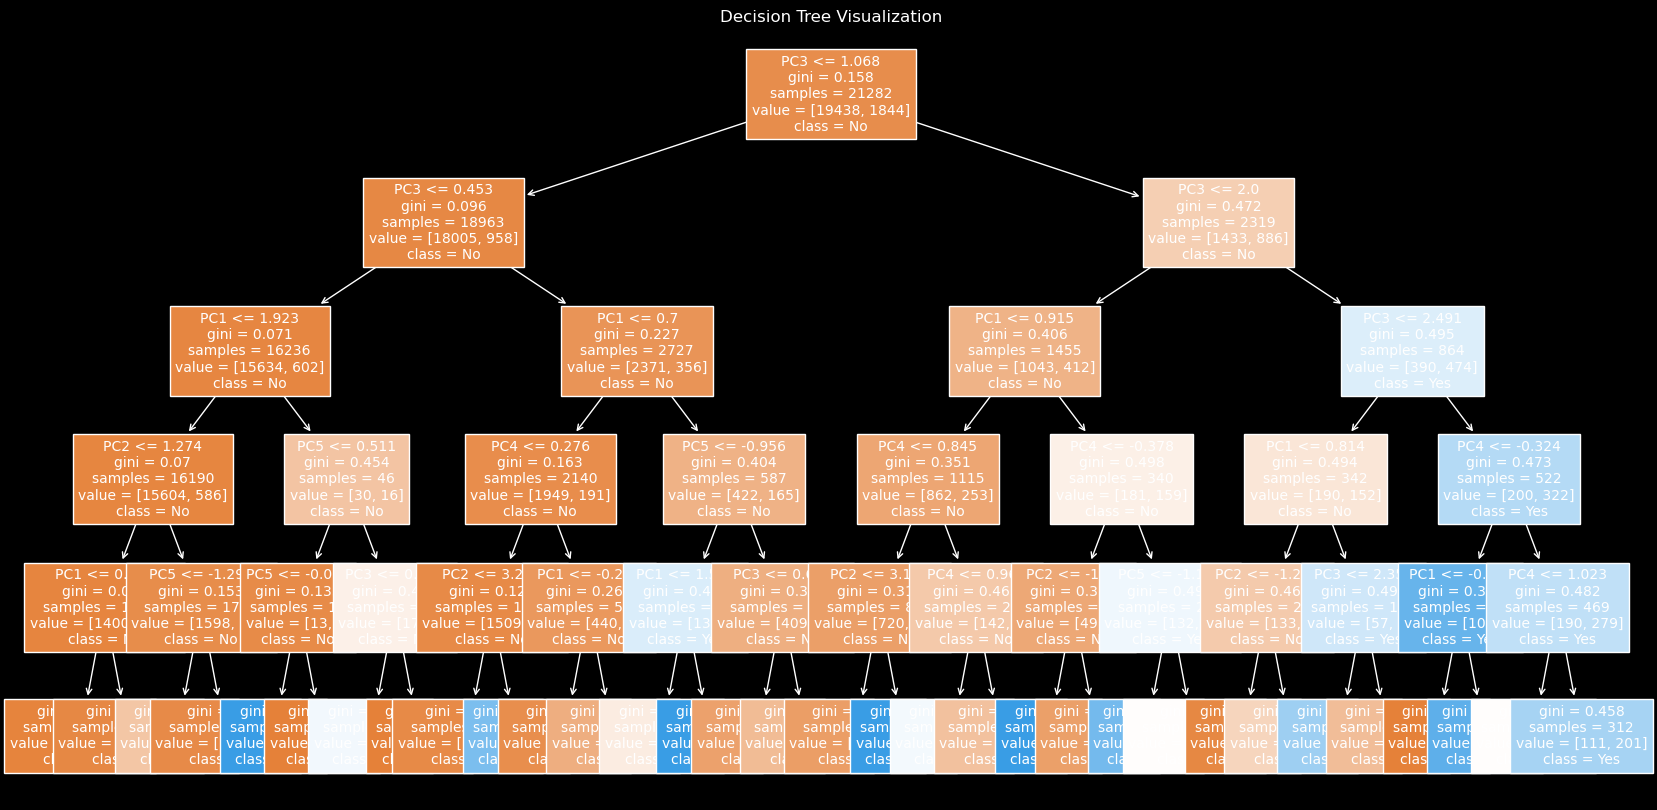

In [14]:
plt.figure(figsize=(20,10))
plot_tree(tree_model, filled=True, feature_names=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], class_names=['No', 'Yes'], fontsize=10)
plt.title('Decision Tree Visualization')
plt.show()

In [15]:
adjusted_feature_names = bank_q1q3_inliers.columns.drop('y')[:7]

loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])], index=adjusted_feature_names)
print('Adjusted PCA Loadings:\
', loadings_df)

Adjusted PCA Loadings:                 PC1       PC2       PC3       PC4       PC5  PC6  PC7
age       -0.209190  0.679451 -0.310010  0.433421 -0.458940  0.0  0.0
job             NaN       NaN       NaN       NaN       NaN  NaN  NaN
marital         NaN       NaN       NaN       NaN       NaN  NaN  NaN
education       NaN       NaN       NaN       NaN       NaN  NaN  NaN
default         NaN       NaN       NaN       NaN       NaN  NaN  NaN
balance    0.026505  0.715309  0.239843 -0.534266  0.380349  0.0  0.0
housing         NaN       NaN       NaN       NaN       NaN  NaN  NaN


## Resultados del Árbol de Decisiones Basado en PCA

*Importancia de la Edad y el Estado Civil*:

Dado que PC1 tiene cargas significativas en age y marital, y si este componente aparece como un criterio de división importante en el árbol, podemos inferir que la edad y el estado civil son factores críticos en la predicción de la respuesta del cliente. Por ejemplo, clientes de cierta edad y estado civil podrían tener más probabilidad de responder 'Yes' o 'No'.

*Relación entre Empleo y Edad*:

Si PC2, que está influenciado fuertemente por job y age, es un punto de división en el árbol, esto sugiere que la combinación de tipo de empleo y edad del cliente también juega un papel importante en sus decisiones financieras o en su respuesta a las campañas del banco.

*Influencia del Nivel Educativo*:

PC3 se destaca por su alta carga en education. Si este componente es utilizado en el árbol para hacer divisiones, indica que el nivel educativo es un predictor significativo de la conducta del cliente. Esto puede ser útil para segmentar campañas basadas en el nivel educativo.

## Implicaciones Prácticas

*Segmentación de Clientes*: El modelo está identificando segmentos específicos de clientes basados en combinaciones de características demográficas y de comportamiento. Esto puede ser utilizado para personalizar productos y servicios o para dirigir comunicaciones de marketing más efectivamente.

*Desarrollo de Producto y Ofertas*: Comprender qué combinaciones de características influyen más en las decisiones de los clientes puede ayudar al banco a diseñar productos que se alineen mejor con las necesidades y preferencias de diferentes segmentos de clientes.

*Estrategias de Marketing*: Las campañas pueden ser más efectivas si se dirigen a grupos de clientes basados en los insights proporcionados por el análisis de PCA y el árbol de decisiones, como enfocarse en clientes jóvenes y educados para productos tecnológicamente avanzados o en clientes mayores para productos de ahorro o inversión.

In [18]:
def encode_categorical_features(df):
    categorical_cols = df.select_dtypes(include=['object']).columns
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    return df_encoded

encoded_df = encode_categorical_features(bank_q1q3_inliers)
encoded_df.head()

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,y_yes
0,58,2143,5,261,1,-1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,44,29,5,151,1,-1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,33,2,5,76,1,-1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,47,1506,5,92,1,-1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,33,1,5,198,1,-1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
